In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, samples=[], start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        self._samples= samples
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
    
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= self.get_random_from_samples()
            #random will effect the result, less than operation will lose gradient
            dI_01= dI>dIsample

            dI= dI*(1-I)
            
            I = torch.max(I, dI_01) # got infected

            states[self._states_names['I']] = I

        return states, dI
    def get_random_from_samples(self):
            if self._samples==[]:
                return torch.rand(self._n).to(device)
            return self._samples[self._t-1]

In [2]:
def sim(time_horizon, population, model, mode="run"):
  log = [population['I']]
  IMeans = [torch.tensor(0).to(device)]
  for i in range(time_horizon):
    population, dI = model(population)
    log.append(population['I'])
    IMeans.append(dI.sum()+IMeans[-1])
  log = torch.stack(log)
  IMeans = torch.stack(IMeans)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log, IMeans

In [3]:
TestCases= [200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
TestNumPer= 20
TestResults= {}

for n in TestCases:
    TestResults[n]= []

for n in TestCases:
    for j in range(TestNumPer):
        print(n, " ", j)
        avgDegree = 10  #every individual will have 10 contacts on average
        pinf = 0.2  #it is the first parameter we are going to fit
        time_horizon = 20
        #create  dense contacts
        contacts = generate_random_network(n, avgDegree)
        contacts = contacts.coalesce()#make pairs unique
        contacts = contacts.to_dense()
        contacts = contacts.requires_grad_(True)
        #random to be used
        dIsamples=[]
        for _ in range(time_horizon):
            dIsamples.append(torch.rand(n).to(device))
        #si true 
        si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                        samples=dIsamples, device=device)
        #si fit
        si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                        samples=dIsamples, device=device)
        #deinfe loss function
        loss_fn = torch.nn.MSELoss(reduction='sum')
        optimizer = torch.optim.Adagrad(si_fit.parameters(), lr=5e-2, weight_decay=1e-2, lr_decay=1e-2)
        #generate real data
        si_result= None
        with torch.no_grad():
            population = Population(n, device=device)
            si_result, _ = sim(time_horizon, population, si, mode="run")
        #dIs_result= dIs_result.sum(dim=1)
        stats_gt   = si_result.sum(dim=3) # si along 20 iterations
        stats_gt   = stats_gt.squeeze()
        stats_gt.requires_grad_(True)
        colors = [("red", 'I')]
        age_sizes = [n]
        fitPinfs=[]
        for i in range(250):
            if i>230:
                fitPinfs.append(si_fit._pinf.item())
            optimizer.zero_grad()
            si_fit._t=0
            population = Population(n, device=device)
            si_pred, IMeans_pred = sim(time_horizon, population, si_fit, mode="train")
            loss = loss_fn(stats_gt, IMeans_pred)
            loss.backward(retain_graph=True)
            optimizer.step()
        print(si_fit._pinf.item())
        TestResults[n].append(sum(fitPinfs)/len(fitPinfs))
        torch.cuda.empty_cache()


200   0
0.1915501058101654
200   1
0.31276631355285645
200   2
0.17531172931194305
200   3
0.16562578082084656
200   4
0.16584043204784393
200   5
0.21495148539543152
200   6
0.12040024250745773
200   7
0.2530260682106018
200   8
0.14277443289756775
200   9
0.14781972765922546
200   10
0.2003859579563141
200   11
0.17112258076667786
200   12
0.2908104956150055
200   13
0.23912635445594788
200   14
0.12720710039138794
200   15
0.20533323287963867
200   16
0.11078771203756332
200   17
0.2926277220249176
200   18
0.1960487812757492
200   19
0.1855320781469345
500   0
0.15019755065441132
500   1
0.18371576070785522
500   2
0.22543559968471527
500   3
0.2400960475206375
500   4
0.16703924536705017
500   5
0.1969483345746994
500   6
0.2121412456035614
500   7
0.20429055392742157
500   8
0.2085694819688797
500   9
0.17894713580608368
500   10
0.2246069759130478
500   11
0.16266438364982605
500   12
0.26810765266418457
500   13
0.17582747340202332
500   14
0.11475212126970291
500   15
0.215455

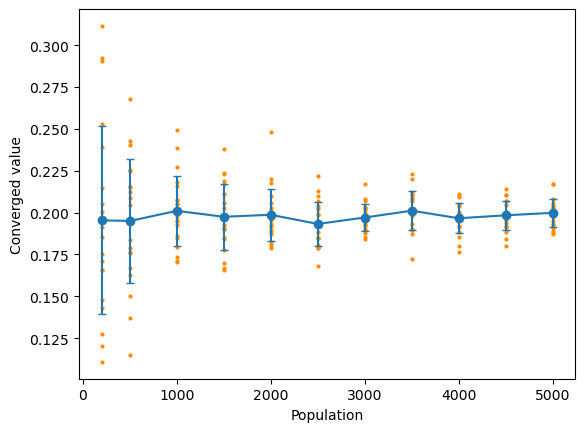

[0.19537022280457772, 0.19498826749622822, 0.20101686986653428, 0.19747769762026635, 0.19868888125607845, 0.1931991398726639, 0.19704823172406147, 0.2011198311652008, 0.19660662989083091, 0.19835395134593312, 0.1998436709375758]
[0.05613704022742436, 0.037133407084536385, 0.020936078241133197, 0.01966984910936271, 0.0156449468890046, 0.013311935273860697, 0.008000463920996705, 0.011821109782913581, 0.009089532560879209, 0.008744226315554106, 0.008316117376046246]


In [4]:
import numpy as np
x=[]
y=[]
xs=[]
means= []
stds= []
for n in TestCases:
    vector= np.array(TestResults[n])
    xs.append(n)
    means.append(np.mean(vector))
    stds.append(np.sqrt(np.var(vector)))
    for m in TestResults[n]:
        x.append(n)
        y.append(m)
plt.scatter(x, y, c="darkorange", s= 4)
plt.errorbar(xs, means, stds, marker='o', capsize=3)
plt.xlabel("Population")
plt.ylabel("Converged value")
plt.show()
print(means)
print(stds)
